In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# GAZ_ZCTA : US 인구 (zcta)

In [ ]:
df_zcta = pd.read_csv('2021/gaz_zcta2016.csv')
df_zcta['rho'] = df_zcta.POP / df_zcta.ALAND

In [ ]:
plt.hist(df_zcta.ALAND, bins=np.arange(100)*1e+6)
plt.title('Dist. of Area'); plt.show()

In [ ]:
plt.hist(df_zcta.POP, bins=np.arange(90)*100)
plt.title('Dist. of Pop'); plt.show()

In [ ]:
plt.hist(df_zcta.rho, bins=np.arange(100)*1e-5)
plt.title('Dist. of $ρ_P$'); plt.show()

# 서울 인구

In [2]:
import geopandas as gpd

In [243]:
fnames = [f'yunu-ingu-20191003/400_{hour}_grid_norm.shp' for hour in range(24)]
gdfs = [gpd.read_file(fname) for fname in fnames]
gdfs[0]

,index,cell_densi,grid_pop,geometry
0,276,0.000048,7.753294,"POLYGON ((935035.255 1950265.548, 935035.255 1..."
1,277,0.000231,37.036723,"POLYGON ((935035.255 1950665.548, 935035.255 1..."
2,278,0.000007,1.109585,"POLYGON ((935035.255 1951065.548, 935035.255 1..."
3,355,0.000054,8.663419,"POLYGON ((935435.255 1949865.548, 935435.255 1..."
4,356,0.000338,54.138815,"POLYGON ((935435.255 1950265.548, 935435.255 1..."
...,...,...,...,...
4038,7635,0.001552,248.343213,"POLYGON ((971835.255 1949865.548, 971835.255 1..."
4039,7636,0.000599,95.815867,"POLYGON ((971835.255 1950265.548, 971835.255 1..."
4040,7637,0.000432,69.190773,"POLYGON ((971835.255 1950665.548, 971835.255 1..."
4041,7638,0.009331,1492.919158,"POLYGON ((971835.255 1951065.548, 971835.255 1..."


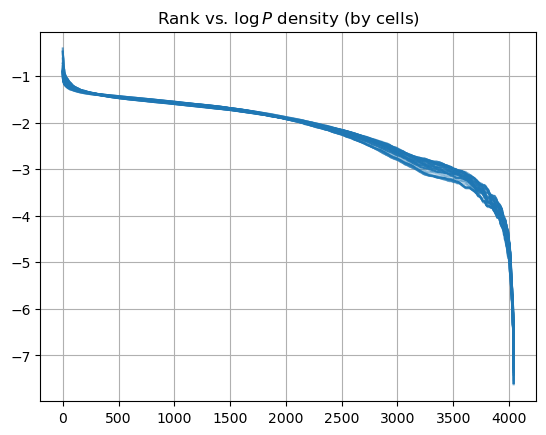

In [244]:
plt.title('Rank vs. $\log P$ density (by cells)')
for h in range(24):
    rank = gdfs[h].cell_densi.sort_values(ascending=False)
    plt.plot(range(len(rank)), np.log10(rank), color='tab:blue', alpha=0.3 + 0.7*h/24)
plt.grid(); plt.show()

In [245]:
V = np.array([.0,.0])
M = gdfs[0].grid_pop.sum()
geo_to_vec = lambda geo: np.array([coord[0] for coord in geo.centroid.xy])
for row in gdfs[0].iloc:
    vec = geo_to_vec(row.geometry)
    V += row.grid_pop*vec
V /= M

mr2 = .0
for row in gdfs[0].iloc:
    r = geo_to_vec(row.geometry) - V
    mr2 += row.grid_pop * np.linalg.norm(r)**2
rog = np.sqrt(mr2/M)

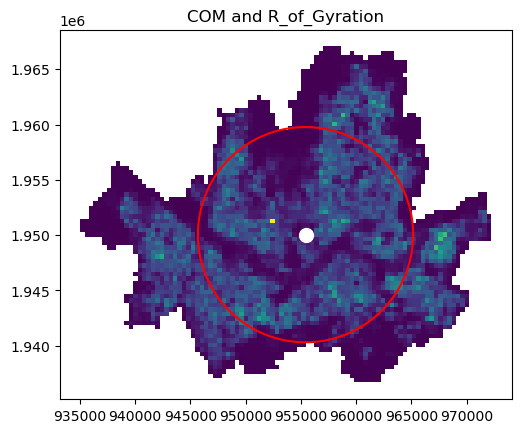

In [246]:
# ~~~ PLOT ~~~
gdfs[0].plot(column='cell_densi')
plt.scatter(*tuple(V), s=100, c='w')

thetas = 2 * np.pi * np.linspace(0,1,100)
rog_X = V[0] + rog*np.cos(thetas)
rog_Y = V[1] + rog*np.sin(thetas)
plt.plot(rog_X, rog_Y, color='r')
plt.title('COM and R_of_Gyration'); plt.show()

In [269]:
arr_V, arr_rog = [], []
for gdf in gdfs:
    V = np.array([.0,.0])
    M = gdf.grid_pop.sum()
    geo_to_vec = lambda geo: np.array([coord[0] for coord in geo.centroid.xy])
    for row in gdf.iloc:
        vec = geo_to_vec(row.geometry)
        V += row.grid_pop*vec
    V /= M

    mr2 = .0
    for row in gdf.iloc:
        r = geo_to_vec(row.geometry) - V
        mr2 += row.grid_pop * np.linalg.norm(r)**2
    rog = np.sqrt(mr2/M)
    
    arr_V.append(V); arr_rog.append(rog)

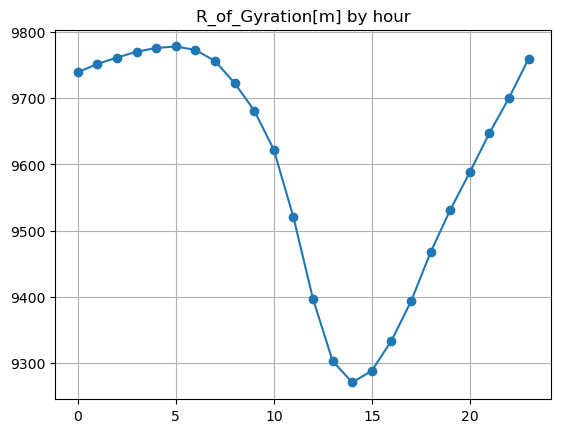

In [248]:
plt.plot(range(24), arr_rog, 'o-')
plt.title('R_of_Gyration[m] by hour'); plt.grid(); plt.show()

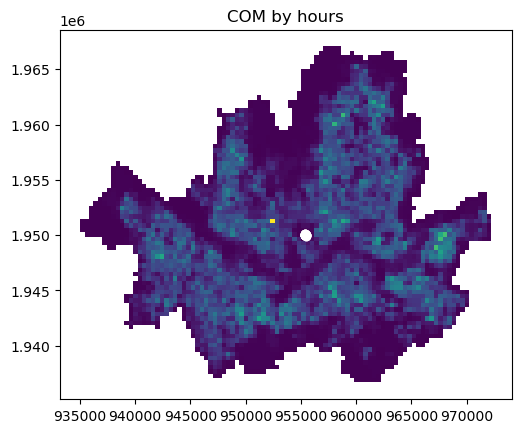

In [249]:
com_X, com_Y = np.array(arr_V).T
gdfs[0].plot(column='cell_densi')
plt.plot(com_X, com_Y, 'o-', color='w')

plt.title('COM by hours'); plt.show()

In [250]:
def Loubar(X):
    X_lorenz = X.cumsum() / X.sum()
    lorX = np.arange(X_lorenz.size)/(X_lorenz.size-1)
    lorY = X_lorenz.to_numpy()
    tangent = (lorY[-1] - lorY[-2])/(lorX[-1] - lorX[-2])
    return lorX[-1] - lorY[-1]/tangent

def draw_hier_loubar_hspots(gdf):
    loubars, Ltiles, dfs_class = [], [], []
    df_sample = gdf
    for level in range(5):
        loubar = Loubar(df_sample.grid_pop.sort_values())
        X = df_sample.grid_pop
        Ltile = np.percentile(X, 100*loubar)
        df_class = df_sample[X >= Ltile]

        loubars.append(loubar)
        Ltiles.append(Ltile)
        dfs_class.append(df_class)

        print(f'Level {level+1} : min={df_class.grid_pop.min()}, max={df_class.grid_pop.max()}')
        df_sample = df_sample[X < Ltile]

    palette = ['red', 'orange', 'yellow', 'green', 'blue']

    fig, ax = plt.subplots()
    for _df, color in zip(dfs_class, palette):
        _df.plot(color=color, ax=ax)
    plt.show()

Level 1 : min=5819.532013419958, max=19757.849731022416
Level 2 : min=2807.4257778989777, max=5815.443088784402
Level 3 : min=1213.7428981982794, max=2805.948536733285
Level 4 : min=492.80304592134314, max=1213.4730724661677
Level 5 : min=177.60348709815523, max=492.3966733193879


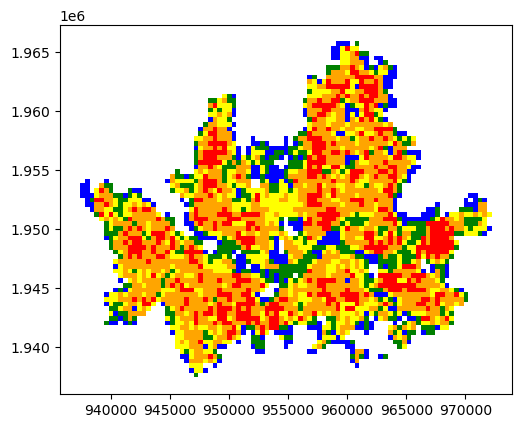

In [338]:
draw_hier_loubar_hspots(gdfs[3])

Level 1 : min=6240.8913892240735, max=30895.16075965412
Level 2 : min=2919.2904519236863, max=6236.377773667277
Level 3 : min=1289.2276403357928, max=2915.157211961083
Level 4 : min=549.210577763271, max=1288.4694960889644
Level 5 : min=228.60137023938242, max=545.2251421998867


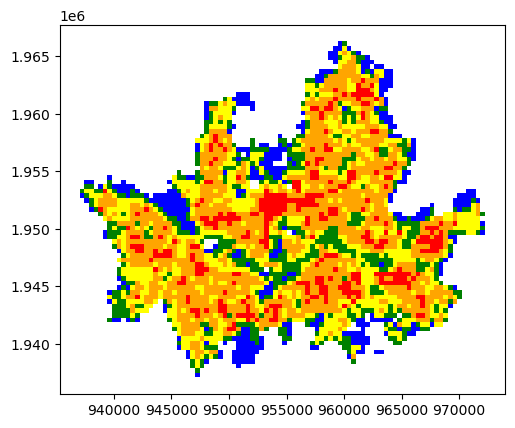

In [339]:
draw_hier_loubar_hspots(gdfs[12])

In [268]:
from scipy.spatial.distance import jensenshannon
from itertools import combinations

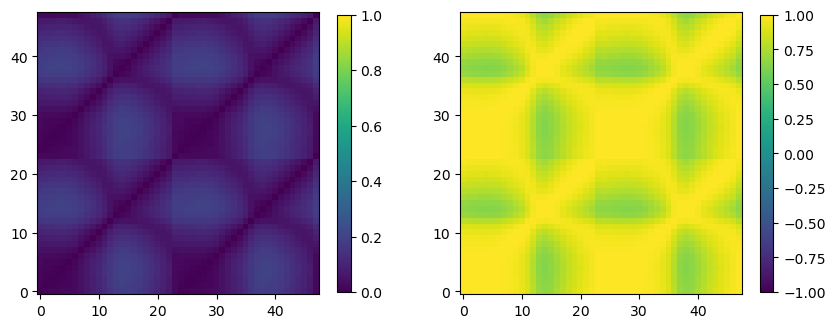

In [316]:
J, C = np.zeros((24,24)), np.ones((24,24))
for i,j in combinations(range(24), 2):
    P, Q = gdfs[i].grid_pop, gdfs[j].grid_pop
    J[i,j] = J[j,i] = jensenshannon(P, Q)
    C[i,j] = C[j,i] = np.corrcoef(P, Q)[1,0]
    
fig, axes = plt.subplots(1, 2, figsize=(10,4.5))

im1 = axes[0].imshow(np.tile(J, (2,2)), origin='lower', vmax=1)
fig.colorbar(im1, ax=axes[0], shrink=0.8, location='right')

im2 = axes[1].imshow(np.tile(C, (2,2)), origin='lower', vmin=-1, vmax=1)
fig.colorbar(im2, ax=axes[1], shrink=0.8, location='right')

plt.show()

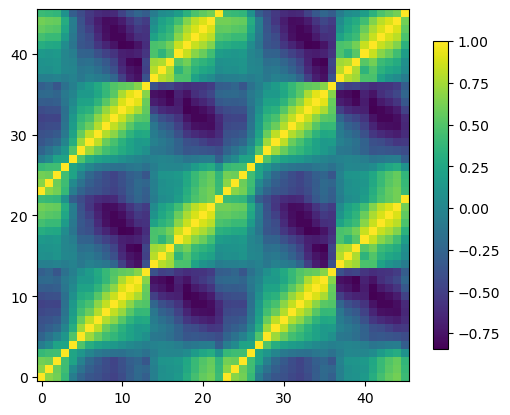

In [321]:
dPdt = [gdfs[i].grid_pop - gdfs[i+1].grid_pop for i in range(23)]
C2 = np.ones((23,23))
for i,j in combinations(range(23), 2):
    U, V = dPdt[i], dPdt[j]
    C2[i,j] = C2[j,i] = np.corrcoef(U, V)[1,0]
    
fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(np.tile(C2, (2,2)), origin='lower', vmax=1)
fig.colorbar(im, ax=ax, shrink=0.8, location='right')
plt.show()

# 서울 속도

In [255]:
arr_df_vel = [pd.read_pickle(f'to_data/Seoul_vel/pickle/{fname}.pickle') for fname in ['202102', '202101', '202012']]
arr_df_vel[0]

,PRCS_YEAR,PRCS_MON,PRCS_DAY,PRCS_HH,PRCS_MIN,LINK_ID,PRCS_SPD
0,2021,2,1,0,0,1020014000,22.809999
1,2021,2,1,0,0,1020014100,27.139999
2,2021,2,1,0,0,1020014200,31.320000
3,2021,2,1,0,0,1020014300,17.000000
4,2021,2,1,0,0,1020014400,32.000000
...,...,...,...,...,...,...,...
40626427,2021,2,28,23,0,1230011900,33.619999
40626428,2021,2,28,23,0,1230012000,39.000000
40626429,2021,2,28,23,0,1230012100,18.650000
40626430,2021,2,28,23,0,1230012200,48.000000


In [256]:
# df_vel_nodeloc = pd.read_csv('to_data/Seoul_vel/metadata/NodeLocInfo.csv', encoding='utf-8')
# df_vel_nosuninfo = pd.read_csv('to_data/Seoul_vel/metadata/info.csv', encoding='cp949')
# df_vel_linkinfo_se = pd.read_csv('to_data/Seoul_vel/metadata/RoadLink_ST+ED_NodeInfo.csv', encoding='utf-8')
df_vel_linkinfo_loc = pd.read_csv('to_data/Seoul_vel/metadata/RoadLink_GRS+GCS_LocInfo.csv', encoding='utf-8')

In [257]:
sample = arr_df_vel[0][['PRCS_HH', 'LINK_ID', 'PRCS_SPD']].groupby(['PRCS_HH', 'LINK_ID']).mean()

In [258]:
def vel_cmap(vel):
    red, yellow, blue = np.array([1, 0, 0.2]), np.array([1, 0.9, 0.1]), np.array([0, 0.1, 0.9])
    vec = [0,0,0]
    if vel <= 70:
        vec = blue + (vel/70)*(yellow - blue)
    else:
        vec = yellow + ((vel-70)/70)*(red - yellow)
    return vec

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


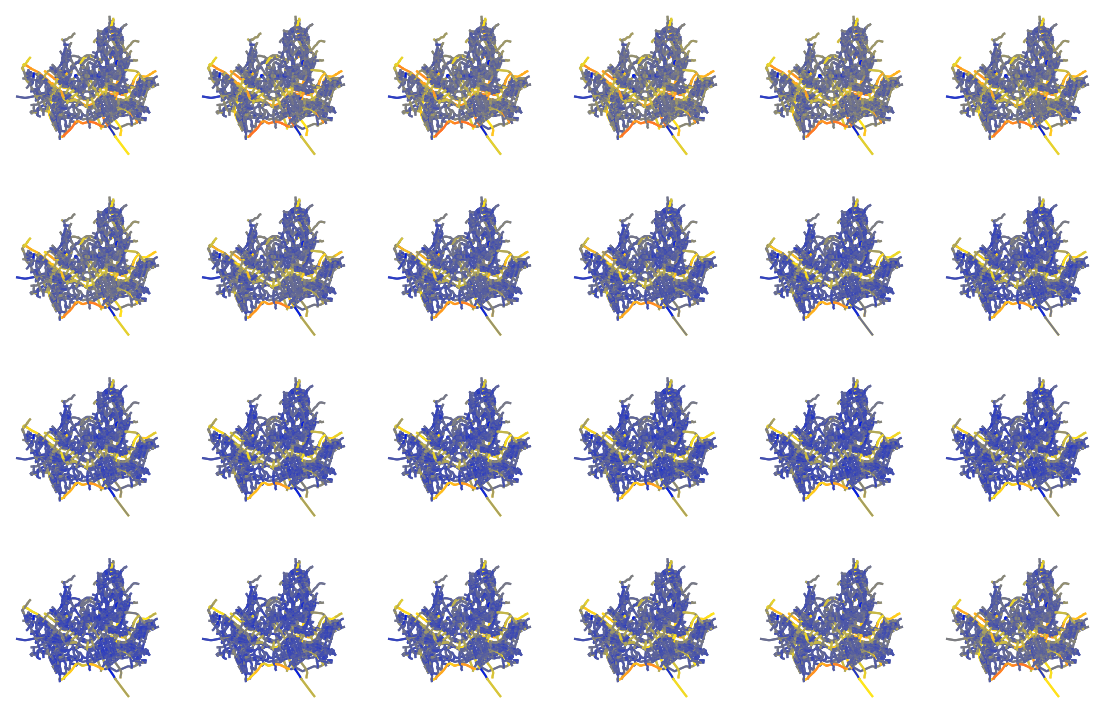

In [259]:
fig, axes = plt.subplots(4, 6, figsize=(14, 9))

idx = 0
for axes_row in axes:
    for ax in axes_row:
        ax.axis('off')
        _df = sample.loc[idx]
        
        link_paths = [df_vel_linkinfo_loc[df_vel_linkinfo_loc.link_id==link].\
              sort_values('ver_seq')[['lon', 'lat']].to_numpy().T\
              for link in sample.loc[0].index]
        for path, vel in zip(link_paths, _df.PRCS_SPD):
            ax.plot(path[0], path[1], '-', color=vel_cmap(vel))
        idx += 1; print(idx)
plt.show()

# 서울 트래픽

In [260]:
import os
fnames = os.listdir('to_data/Seoul_traffic/')[:-1] # exclude README
for i, fname in enumerate(fnames): print(i, fname)

with open('to_data/Seoul_traffic/' + fnames[-1], 'r', encoding='cp949') as f:
    header = f.readline().split('\t')[:-1]
df_traf = pd.read_csv('to_data/Seoul_traffic/' + fnames[-1], encoding='cp949', header=None, skiprows=1)
df_traf.columns = header
df_traf

0 A(도심) 1분.txt
1 남산권(A-20 A-21 A-22 A-24).txt
2 B(시계) 1분.txt
3 C(교량) 1분.txt
4 D(간선도로) 1분.txt
5 F(도시고속) 1분.txt


,LOCATION,REALTIME_ID,AHEAD,IN_DATE,IN_TIME,INITLANE,VOL
0,'올림픽대로','F-01','유입','20210101','0000','1','5'
1,'올림픽대로','F-01','유입','20210101','0001','1','6'
2,'올림픽대로','F-01','유입','20210101','0002','1','6'
3,'올림픽대로','F-01','유입','20210101','0003','1','8'
4,'올림픽대로','F-01','유입','20210101','0004','1','7'
...,...,...,...,...,...,...,...
4780808,'서부간선도로','F-09','유출','20210228','2355','3','0'
4780809,'서부간선도로','F-09','유출','20210228','2356','3','1'
4780810,'서부간선도로','F-09','유출','20210228','2357','3','0'
4780811,'서부간선도로','F-09','유출','20210228','2358','3','0'


# 서울 이동

In [328]:
import os
fnames = os.listdir('to_data/Seoul_move/utf8/high_res/')[:-1] # exclude README

arr_date = [None for i in range(len(fnames))]
arr_df = [None for i in range(len(fnames))]
for i, fname in enumerate(fnames):
    Y, M, D = map(int, [fname[:4], fname[4:6], fname[7:9]])
    if (Y,M) != (2020, 1): continue
    print(Y, M, D)
    arr_date[i] = [Y, M, D]
    arr_df[i] = pd.read_csv(f'to_data/Seoul_move/utf8/high_res/{fname}')
    
data_move = [dict(file=fname, ymd=date, df=df) for fname, date, df in zip(fnames, arr_date, arr_df)]

2020 1 0
2020 1 1
2020 1 2
2020 1 3
2020 1 4
2020 1 5
2020 1 6
2020 1 7
2020 1 8
2020 1 9
2020 1 10
2020 1 11
2020 1 12
2020 1 13
2020 1 14
2020 1 15
2020 1 16
2020 1 17
2020 1 18
2020 1 19
2020 1 20
2020 1 21
2020 1 22
2020 1 23


In [329]:
data_move[0]['df']

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
0,202001,일,0,1101053,1101053,F,10,EE,20,5.93
1,202001,일,0,1101053,1101053,F,20,HH,10,6.05
2,202001,일,0,1101053,1101053,F,20,EH,10,*
3,202001,일,0,1101053,1101053,F,20,EE,20,4.4
4,202001,일,0,1101053,1101053,F,20,WE,10,*
...,...,...,...,...,...,...,...,...,...,...
3000262,202001,토,0,39000,1125072,F,20,EH,80,*
3000263,202001,토,0,39000,1125072,F,60,EW,70,3.83
3000264,202001,토,0,39000,1125073,F,45,EH,140,3.33
3000265,202001,토,0,39000,1125073,M,40,EE,60,3.02


In [337]:
data_move[1]['df'][]

,대상연월,요일,도착시간,출발 행정동 코드,도착 행정동 코드,성별,나이,이동유형,평균 이동 시간(분),이동인구(합)
0,202001,일,1,1101053,1101053,F,10,EH,20,5.93
1,202001,일,1,1101053,1101053,F,20,EH,10,*
2,202001,일,1,1101053,1101053,F,25,HH,30,*
3,202001,일,1,1101053,1101053,F,25,EH,10,6.05
4,202001,일,1,1101053,1101053,F,25,EE,20,*
...,...,...,...,...,...,...,...,...,...,...
1807586,202001,토,1,39000,1125051,M,50,EH,100,3.29
1807587,202001,토,1,39000,1125053,M,55,EE,70,3.28
1807588,202001,토,1,39000,1125054,F,50,EH,110,3.12
1807589,202001,토,1,39000,1125061,F,15,EH,80,4.06


In [333]:
import os
fnames = os.listdir('to_data/Seoul_pop/2021/')

arr_date = [None for i in range(len(fnames))]
arr_df = [None for i in range(len(fnames))]
for i, fname in enumerate(fnames):
    Y, M, D = map(int, [fname[13:17], fname[17:19], fname[19:21]])
    if (Y,M) != (2021, 1): continue
    print(Y,M,D)
    arr_date[i] = [Y, M, D]
    arr_df[i] = pd.read_csv(f'to_data/Seoul_pop/2021/{fname}', encoding='cp949')
    
data_pop = [dict(file=fname, ymd=date, df=df) for fname, date, df in zip(fnames, arr_date, arr_df)]

2021 1 1
2021 1 2
2021 1 3
2021 1 4
2021 1 5
2021 1 6
2021 1 7
2021 1 8
2021 1 9
2021 1 10
2021 1 11
2021 1 12
2021 1 13
2021 1 14
2021 1 15
2021 1 16
2021 1 17
2021 1 18
2021 1 19
2021 1 20
2021 1 21
2021 1 22
2021 1 23
2021 1 24
2021 1 25
2021 1 26
2021 1 27
2021 1 28
2021 1 29
2021 1 30
2021 1 31


In [336]:
data_pop[0]['df']

,"?""기준일ID""",시간대구분,행정동코드,집계구코드,총생활인구수,남자0세부터9세생활인구수,남자10세부터14세생활인구수,남자15세부터19세생활인구수,남자20세부터24세생활인구수,남자25세부터29세생활인구수,...,여자25세부터29세생활인구수,여자30세부터34세생활인구수,여자35세부터39세생활인구수,여자40세부터44세생활인구수,여자45세부터49세생활인구수,여자50세부터54세생활인구수,여자55세부터59세생활인구수,여자60세부터64세생활인구수,여자65세부터69세생활인구수,여자70세이상생활인구수
0,20210101,0,11110515,1101072010001,535.4159,23.9304,15.2485,20.0336,17.0057,19.0733,...,13.6096,16.0952,17.484,28.7919,28.3058,24.5215,27.688,10.2262,9.9532,41.2273
1,20210101,0,11110515,1101072010002,771.8753,19.4261,12.3783,16.0527,22.2533,30.5092,...,36.5139,25.465,24.7023,25.6652,44.0503,31.6675,25.0082,24.8237,16.6902,77.887
2,20210101,0,11110515,1101072010003,492.3513,31.2421,19.9075,27.8869,32.7721,10.4105,...,6.1219,6.5623,12.624,28.8514,24.5123,17.7318,17.8168,5.5643,13.5577,52.2181
3,20210101,0,11110515,1101072010004,242.6896,7.5118,4.7865,7.228,4.8051,14.4898,...,9.994,8.2866,12.2186,7.7387,9.7159,10.4081,10.7771,10.6976,*,15.1061
4,20210101,0,11110515,1101072010005,543.0731,32.2627,20.5579,28.5246,31.8696,13.0143,...,8.124,9.4217,14.605,31.5859,27.5614,20.7399,21.692,6.766,13.8002,53.9013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459643,20210101,23,11740700,1125071022201,991.2717,21.9763,11.086,43.9865,23.1507,31.1229,...,24.0008,30.4194,47.5859,47.6423,45.694,57.1907,47.1525,45.6463,25.4602,65.5896
459644,20210101,23,11740700,1125071022202,251.3992,5.4833,*,11.8769,5.7227,7.8081,...,5.9024,8.066,11.6816,12.1321,11.4011,14.905,12.2067,11.4932,6.1789,16.6905
459645,20210101,23,11740700,1125071022501,499.7120,16.0406,8.0918,12.191,6.3775,16.4967,...,19.1852,25.169,15.188,27.3004,17.7879,15.9876,19.7014,15.4582,20.6578,39.7683
459646,20210101,23,11740700,1125071022701,120.0074,*,*,4.6788,*,*,...,*,*,6.695,4.2539,5.5288,4.7326,6.4901,*,4.7013,10.2893


In [5]:
gpd.read_file('kontur_population.gpkg')

,h3,population,geometry
0,88f3a6db3bfffff,1.0,"POLYGON ((18603209.750 -14292976.859, 18601045..."
1,88f3a6db17fffff,1.0,"POLYGON ((18606931.516 -14291748.852, 18604767..."
2,88f2a40257fffff,1.0,"POLYGON ((-18642103.219 -18440071.312, -186432..."
3,88f1b4575dfffff,1.0,"POLYGON ((13731045.703 -12978244.008, 13729880..."
4,88f1b45755fffff,2.0,"POLYGON ((13727729.906 -12976687.297, 13726565..."
...,...,...,...
32589548,8800189467fffff,8.0,"POLYGON ((5291540.844 16071094.984, 5294861.62..."
32589549,8800189465fffff,3.0,"POLYGON ((5292353.844 16065218.406, 5295671.59..."
32589550,880018942dfffff,1.0,"POLYGON ((5296117.406 16074489.078, 5299440.40..."
32589551,8800189425fffff,2.0,"POLYGON ((5300699.219 16077882.031, 5304024.43..."


# KTDB (2019DAS)

In [ ]:
pd.read_pickle('to_data/ktdb/2019DAS/pickle/01/01.pickle')

# NHTS : US출퇴근OD (county)
😐 583 counties out of 3006

In [ ]:
df_nhts = pd.read_csv('us_nhts/2020_Passenger_OD_Annual.csv')
df_nhts = df_nhts.loc[:,:'purpose_nonwork']
df_nhts